# Pytorch的动态图、自动求导及逻辑回归
## 1.简介
- 简介
- pytorch的动态图机制
- pytorch的自动求导机制
- 实现一个逻辑回归

这一章节主要讲解Pytorch的动态图机制,讲了计算图的概念和作用,并且说明了Pytorch的动态图机制.
讲解了Pytorch的自动求导机制,最后实现了一个逻辑回归

## 2.Pytorch的动态图机制
计算图是用于描述运算的有向无环图(注意是无环图不是五环图,原博客写错了).计算图用节点和边来表示计算的过程.如下图所示:  
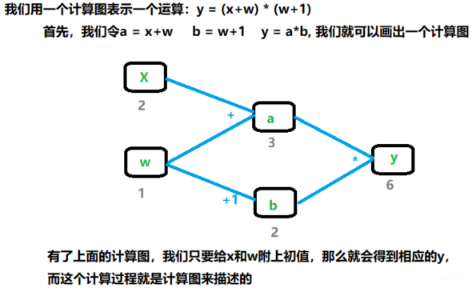  
上图节点表示数据和变量,边表示运算.  
使用计算图可以简洁地表示出运算过程并且可以简化梯度的求解.如下图所示:  
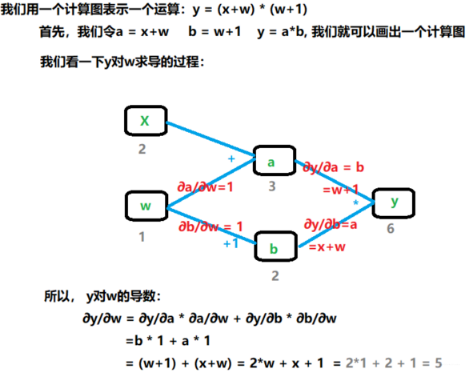  
在上图中,展示出了y对w求导的过程,只需要找到w到y的全部路径,分别求导然后将导数相加即可.下面的程序可以验证这个过程:

In [51]:
import torch
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)

y.backward()
print(w.grad)   # tensor([5.])


tensor([5.])


### 叶子节点
叶子结点是参与运算的最底层变量.也就是在计算图中的叶子节点处的变量.叶子节点的`is_leaf`属性为True.并且为了节省内存,每次反向传播后都会释放非叶子节点的梯度,只保留叶子节点的梯度.当然,如果要保留非叶子节点的梯度,也可以使用方法`retain_grad()`来实现.

In [52]:
#查看叶子结点
print("is_leaf:\n", w.is_leaf, x.is_leaf, a.is_leaf, b.is_leaf, y.is_leaf)
#查看梯度， 默认是只保留叶子节点的梯度的
print("gradient:\n", w.grad, x.grad, a.grad, b.grad, y.grad)

is_leaf:
 True True False False False
gradient:
 tensor([5.]) tensor([2.]) None None None


c:\Users\TownBoats\.conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:485.)
  after removing the cwd from sys.path.


In [54]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
a.retain_grad()
b = torch.add(w, 1)
y = torch.mul(a, b)

y.backward()
#查看梯度， 默认是只保留叶子节点的梯度的
print("gradient:\n", w.grad, x.grad, a.grad, b.grad, y.grad)

#a变量使用retain_grad()方法后,梯度被保留下来了.


gradient:
 tensor([5.]) tensor([2.]) tensor([2.]) None None


c:\Users\TownBoats\.conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:485.)
  # This is added back by InteractiveShellApp.init_path()


### grad_fn属性
`grad_fn`属性记录了得到该张量时使用的方法,函数等.往往只有非叶节点的这个属性值才有意义,叶节点是初始化得到的,其`grad_fn`属性值为None.自动求导机制是通过`grad_fn`实现的.

### Pytorch是动态图机制
根据计算图的搭建方式,可以将计算图分为动态图和静态图.
- TensorFlow是静态图,高效但不灵活
- Pytorch是动态图,灵活易调节

## 3.自动求导机制
这里仅列出一些我觉得需要注意的点,就不详细书写了.  
- 使用torch.autograd.grad()可以对目标进行高阶求导
- 叶子节点不能进行原位操作 比如`a += torch.ones((1,))`这种

## 4.实现一个逻辑回归

In [49]:
import torch

#数据生成

data_num = 100
mean_value = 1.8

x0 = torch.normal(mean_value,1,[data_num,2])
y0 = torch.zeros(data_num)
x1 = torch.normal(-mean_value,1,[data_num,2])
y1 = torch.ones(data_num)

x_train = torch.cat([x0,x1],dim=0)
y_train = torch.cat([y0,y1],dim=0)
print(x_train.shape)

torch.Size([200, 2])


In [42]:
#构建模型
#第一种写法, sequential搭建

lr_net = torch.nn.Sequential(
    torch.nn.Linear(2,1),
    torch.nn.Sigmoid()
    )



#第二种写法,继承Module.nn类
class LR(torch.nn.Module):
    def __init__(self):
        super(LR,self).__init__()
        self.features = torch.nn.Linear(2,1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self,x):
        x = self.features(x)
        x = self.sigmoid(x)
        return x

lr_net = LR()

In [43]:
#损失函数
loss_fn = torch.nn.BCELoss()

In [45]:
#优化器
lr = 0.05
optimizer = torch.optim.SGD(lr_net.parameters(), lr=lr, momentum=0.9)

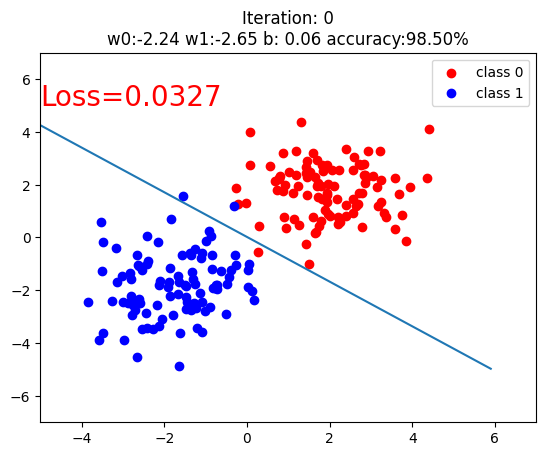

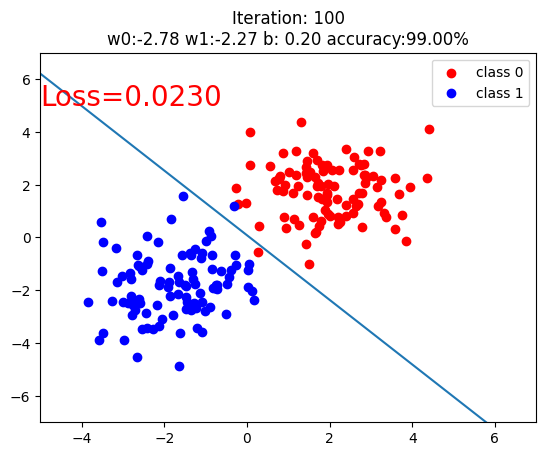

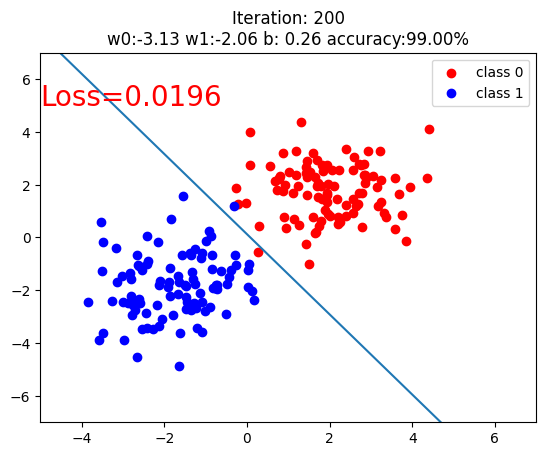

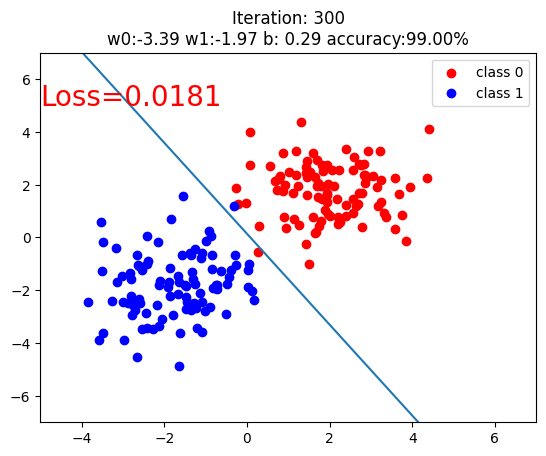

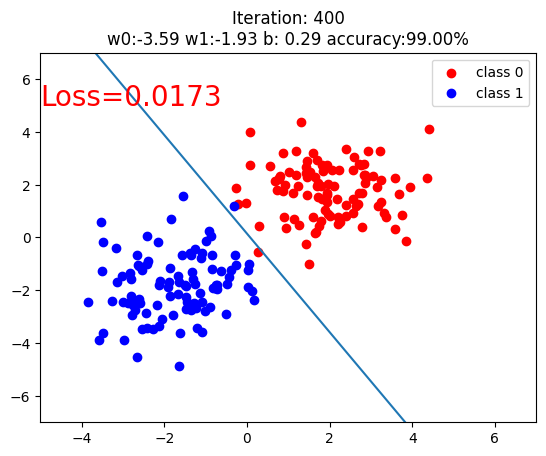

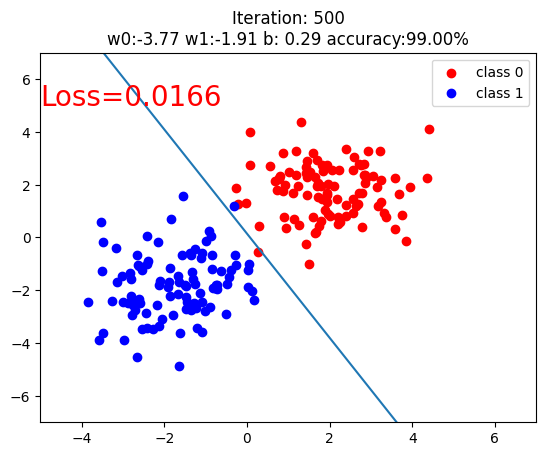

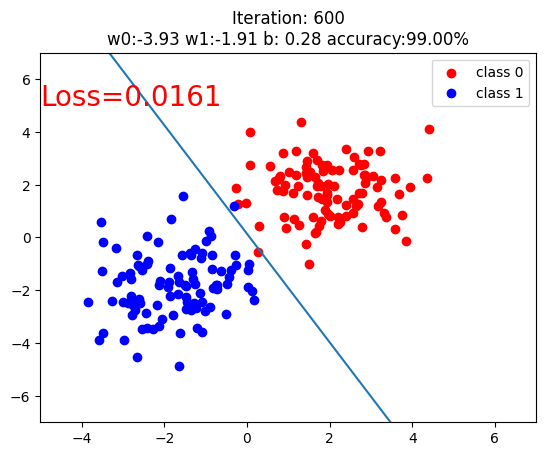

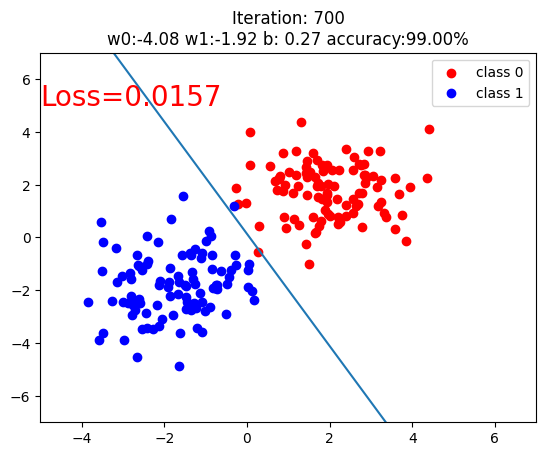

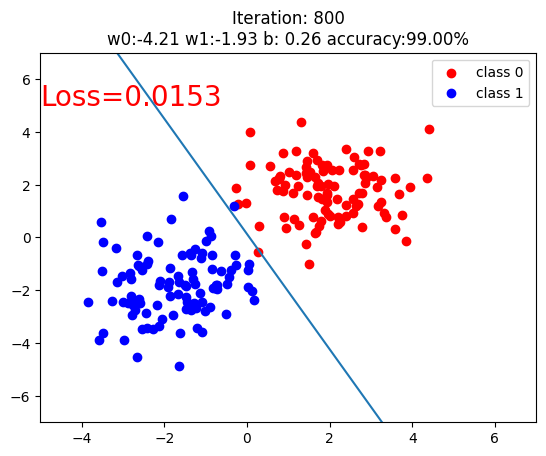

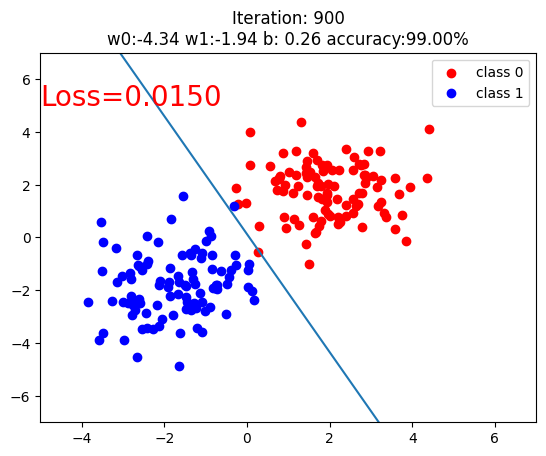

In [50]:
#训练过程
import matplotlib.pyplot as plt
import numpy as np
for i in range(1000):
    y_pred = lr_net(x_train)

    loss = loss_fn(y_pred.squeeze(),y_train)

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()
    if i % 100 == 0:

        mask = y_pred.ge(0.5).float().squeeze()  # 以0.5为阈值进行分类
        correct = (mask == y_train).sum()  # 计算正确预测的样本个数
        acc = correct.item() / y_train.size(0)  # 计算分类准确率

        plt.scatter(x0.data.numpy()[:, 0], x0.data.numpy()[:, 1], c='r', label='class 0')
        plt.scatter(x1.data.numpy()[:, 0], x1.data.numpy()[:, 1], c='b', label='class 1')

        w0, w1 = lr_net.features.weight[0]
        w0, w1 = float(w0.item()), float(w1.item())
        plot_b = float(lr_net.features.bias[0].item())
        plot_x = np.arange(-6, 6, 0.1)
        plot_y = (-w0 * plot_x - plot_b) / w1

        plt.xlim(-5, 7)
        plt.ylim(-7, 7)
        plt.plot(plot_x, plot_y)

        plt.text(-5, 5, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color': 'red'})
        plt.title("Iteration: {}\nw0:{:.2f} w1:{:.2f} b: {:.2f} accuracy:{:.2%}".format(i, w0, w1, plot_b, acc))
        plt.legend()

        plt.show()
        plt.pause(0.5)

        if acc > 0.99:
            break